In [1]:
using Turing, Distributions
using Reactive, Interact, Gadfly, Compose

[PG]: Finshed within 1.4133470058441162 seconds


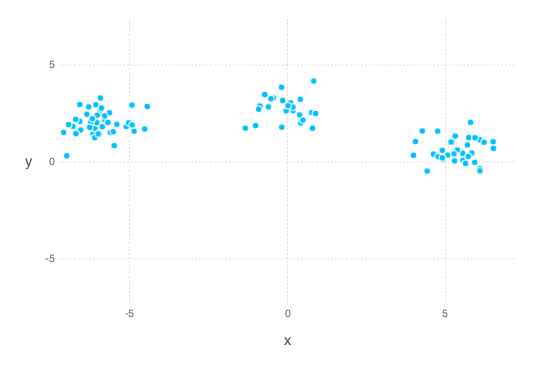

In [2]:
M = 3 # number of clusters
N = 100 # number of data points 
srand(124)


mu_true = [2., 2.]
Sig_true = eye(2)*20
Sig_true[1,2] = Sig_true[2,1] = 0.25

mus = rand(MultivariateNormal(mu_true, Sig_true), M)

@model gmm() = begin
    xs = TArray{Vector}(N)
    cs = tzeros(Int, N)
    for i = 1:N
        cs[i] ~ Categorical(M)
        xs[i] ~ MvNormal(mus[:,cs[i]], [1/2 0; 0 1/2])
    end
    return(mus, cs, xs)
end

chain = @sample(gmm(), PG(10, 2))
xs = chain.value[1].value[:xs]
# Plot data points
d_layer = layer(x=map(e -> e[1], xs), y=map(e -> e[2], xs), Geom.point)

plot(d_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

In [26]:
N = length(xs)
M = 3

@model gmm8(y) = begin
    mus1 = TArray(Vector{Float64}, M)
    for i = 1:M
      mus1[i] ~ MultivariateNormal(mu_true, Sig_true)
    end
    
    z = tzeros(Int, N)
    for i = 1:N
        z[i] ~ Categorical(M)
        y[i] ~ MvNormal(mus1[z[i]], [1/2 0; 0 1/2])
    end
    return(mus, z)
end

gmm8 (generic function with 4 methods)

In [27]:
g = Gibbs(100, HMC(2, 0.2, 5, :mus1), PG(10, 2, :z))
chain = @sample(gmm8(xs), g);

mus = mean(chain[:mus1]);
cs = mean(chain[:z]);

LoadError: MethodError: Cannot `convert` an object of type Array{Int64,1} to an object of type ForwardDiff.Dual{N,T<:Real}
This may have arisen from a call to the constructor ForwardDiff.Dual{N,T<:Real}(...),
since type constructors fall back to convert methods.

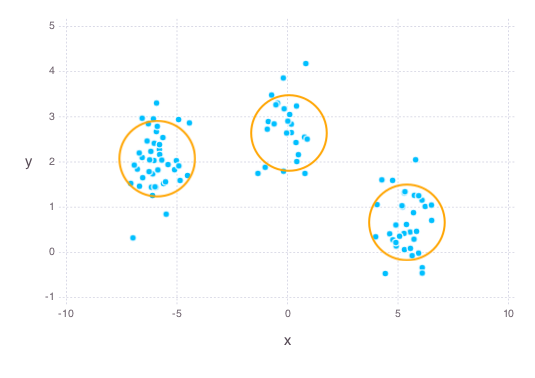

In [10]:
plot(d_layer, 
    Guide.annotation(
compose(context(), circle(mus[1,:], mus[2,:], [10mm]), fill(nothing), stroke(colorant"orange"))
    ))